In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from random import choice

In [2]:
links = pd.read_csv("./data/stack_network_links.csv")
nodes = pd.read_csv("./data/stack_network_nodes.csv")

In [3]:
def get_adj(nodes, edges, label_a="source", label_b="target"):
    NN = len(nodes.unique())
    mappings = {}
    c=0
    adj = np.zeros((NN,NN))
    
    for e in edges.index:
        i, j = edges.loc[e, label_a], edges.loc[e, label_b]
        if i in mappings:
            i = mappings[i]
        else:
            mappings[i]=i=c
            c+=1
        if j in mappings:
            j = mappings[j]
        else:
            mappings[j]=j=c
            c+=1
        adj[i, j] = 1
    return adj, mappings

graph, maps = get_adj(nodes.name, links)

In [4]:
A = (graph!=0)*1

In [5]:
graph_array = { i: np.where( row!=0 )[0] for i, row in enumerate(A)}

In [6]:
def generate_random_walk(start_node, graph, N_steps):
    walk = [start_node]
    for i in range(N_steps):
        walk.append(choice(graph[walk[-1]]))
    return walk

In [7]:
generate_random_walk(0, graph_array, 5)

[0, 20, 19, 20, 21, 20]

In [8]:
def generate_walks(N, graph, min_len=5, max_len=20):
    nodes = tuple(graph.keys())
    return [ generate_random_walk(
        choice(nodes), 
        graph, 
        choice(range(min_len, max_len+1))
    ) for _ in range(N)]


In [9]:
import tensorflow as tf
from tensorflow.keras import (models, layers, metrics, initializers as init)

In [10]:
walks = generate_walks(1500, graph_array)

In [11]:
def get_context(walks, wsize=2):
    dataset = {}
    
    for walk in walks:
        N = len(walk)
        
        for i in range(wsize, N - wsize):
            current_node = walk[i]
            context_node = tuple()
            for j in range(1,wsize + 1):
                prev_node = walk[i - j]
                future_node = walk[i + j]
                
                context_node = context_node + (prev_node, future_node)
            context_node = tuple(sorted(context_node))
            
            dataset[context_node] = dataset.get(context_node, set()) | {current_node}
    return dataset

In [12]:
def unwind(dataset: dict):
    X = []
    y = []
    
    for item in dataset.items():
        xsample, ysamples = item
        for y_value in ysamples:
            X.append(xsample)
            y.append(y_value)
    return np.array(X), np.array(y).reshape(-1,1)

In [34]:
wsize=2

ds = get_context(walks, wsize)
len(ds)

4772

In [35]:
X,y = unwind(ds)

In [36]:
M = len(graph_array)
EMB_SIZE=50

In [37]:
model = models.Sequential([
    layers.Embedding(
        input_dim=M, 
        output_dim=EMB_SIZE, 
        input_length=wsize*2,
        name="embeding_layer"),
    layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), output_shape=EMB_SIZE, name="mean_layer"),
    layers.Dense(units=M, activation="softmax", name="activation_layer")
])

In [38]:
model.compile("adam", loss="sparse_categorical_crossentropy")

In [41]:
model.fit(x=X, y=y, batch_size=64, epochs=10)

Epoch 1/10
138/138 [==============================] - 1s 6ms/step - loss: 1.8186
Epoch 2/10
138/138 [==============================] - 1s 6ms/step - loss: 1.8185
Epoch 3/10
138/138 [==============================] - 1s 6ms/step - loss: 1.8162
Epoch 4/10
138/138 [==============================] - 1s 6ms/step - loss: 1.8155
Epoch 5/10
138/138 [==============================] - 1s 6ms/step - loss: 1.8148
Epoch 6/10
138/138 [==============================] - 1s 6ms/step - loss: 1.8138
Epoch 7/10
138/138 [==============================] - 1s 6ms/step - loss: 1.8124
Epoch 8/10
138/138 [==============================] - 1s 6ms/step - loss: 1.8115
Epoch 9/10
138/138 [==============================] - 1s 6ms/step - loss: 1.8107
Epoch 10/10
138/138 [==============================] - 1s 6ms/step - loss: 1.8104


In [42]:
latent_vectors = model.get_layer("embeding_layer").weights[0].numpy()

### Supervised Learning

In [43]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, 
                             matthews_corrcoef, accuracy_score)

In [44]:
order = np.argsort(nodes.name.map(maps))
y_ = nodes.loc[ order, "group" ]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(latent_vectors, y_, test_size=0.2, random_state=3)

In [46]:
svc = SVC().fit(X_train, y_train)
lr = LogisticRegression(max_iter=9999).fit(X_train, y_train)
print(f"SVC score = {svc.score(X_train, y_train):.3f}\nLR score = {lr.score(X_train, y_train):.3f}")

SVC score = 1.000
LR score = 1.000


In [47]:
print(
    "Random Assignment Score =",accuracy_score(y_train, np.random.randint(1,14+1, len(y_train)))
)

Random Assignment Score = 0.06521739130434782


In [48]:
svc_preds = svc.predict(X_test)
lr_preds = lr.predict(X_test)

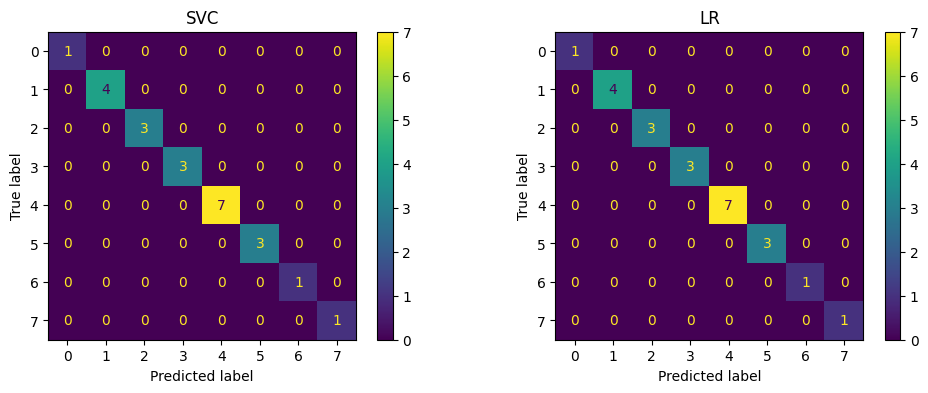

In [49]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,2,figsize=(12,4))
ConfusionMatrixDisplay(confusion_matrix(y_test, svc_preds)).plot(ax=ax[0])
ConfusionMatrixDisplay(confusion_matrix(y_test, lr_preds)).plot(ax=ax[1])

ax[0].set_title("SVC");
ax[1].set_title("LR");

In [50]:
print(f"SVC mcc score = {matthews_corrcoef(y_test, svc_preds):.3f}\nLR mcc score = {matthews_corrcoef(y_test, lr_preds):.3f}")

SVC mcc score = 1.000
LR mcc score = 1.000


In [51]:
print(f"SVC acc score = {accuracy_score(y_test, svc_preds):.3f}\nLR acc score = {accuracy_score(y_test, lr_preds):.3f}")

SVC acc score = 1.000
LR acc score = 1.000


In [52]:
print(
    "Random Assignment Score =",accuracy_score(y_test, np.random.randint(1,14+1, len(y_test)))
)

Random Assignment Score = 0.043478260869565216
